In [1]:
using Turing
using LazyArrays
using StatsPlots
using StatisticalRethinking;
using DataFrames
using Optim
using StatsBase
using RCall

In [2]:
@rlibrary(CDM)

In [3]:
R"""
data(data.ecpe, package="CDM")
X <- data.ecpe$data[,-1]
Q <- data.ecpe$q.matrix
""";
@rget X;
@rget Q;

 $$\eta_{ij} = \Pi_{k=1}^K \alpha_{ik}^{q_{jk}}$$
 
 $$s_{i} \sim Beta()$$
 $$g_{i} \sim Beta()$$
 $$P_{ij} = g_j^{1-\eta_{ij}}(1-s_j^{\eta_{ij}})$$
 $$X_{ij} \sim Bernouli(P_{ij})$$

In [7]:
@model function DINA(X_Matrix, Q_Matrix)
    I = size(X_Matrix)[1]
    J,K = size(Q_Matrix)
    
    s ~ filldist(Beta(1,1),J)
    g ~ arraydist(Truncated.(Beta(1,1), 0, 1 .- s))
    
    delta = fill(1,K)
    C = all_patterns([0,1],I)
    α = generate_α(C,K)
    η = compute_η(α, Q_Matrix)
    
    p = Matrix{Float64}(undef, I,J)
    for i in 1:I
        for j in 1:J
            p[i,j] = g[j] + (1 - s[j] - g[j]) * η[i,j]
        end
    end
    
    for i in 1:I
        for j in 1:J
            X_Matrix[i,j] ~ Bernouli(p[i,j])
        end
    end
end

DINA (generic function with 1 method)

In [4]:
function all_patterns(C,N)
    Matrix(transpose(hcat(collect.(reverse.(Iterators.product(fill(C,N)...))[:])...)))
end

all_patterns (generic function with 1 method)

In [8]:
dina_model =DINA(Matrix(X), Matrix(Q))

DynamicPPL.Model{var"#1#2", (:X_Matrix, :Q_Matrix), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}}(:DINA, var"#1#2"(), (X_Matrix = [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], Q_Matrix = [1 1 0; 0 1 0; … ; 1 0 0; 0 0 1]), NamedTuple())

In [ ]:
sample(dina_model, PG(10),10)

In [126]:
A = [0 1; 1 0;1 1]
Q = [0 1; 1 0; 1 1]

eta = Array{Int64}(undef, 2,3)
for i in 1:2
    for j in 1:3 
        eta[i,j] = prod(A[i,:].^Q[j,:])
    end
end

In [5]:
function compute_η(A,Q)
    I = size(A)[1]
    J, K = size(Q)
    
    eta = typeof(A)(undef, I,J)
    for i in 1:I
        for j in 1:J 
            eta[i,j] = prod(A[i,:].^Q[j,:])
        end
    end
    return eta
end 

compute_η (generic function with 1 method)

In [131]:
compute_η(A,Matrix(Q))

LoadError: InexactError: Int64(0.041000663895270496)

In [179]:
compute_η(A, Matrix(Q))

8×28 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  1  1  0  0  1  0  0  0  0     0  1  1  0  0  1  0  0  0  1  0  1
 0  1  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  1  1  0  0  0  0
 0  1  0  1  1  1  0  1  1  0  0  0  0     1  1  1  0  0  1  1  1  0  1  0  1
 0  0  0  0  0  0  0  0  0  1  0  0  1     0  0  0  0  0  0  0  0  1  0  1  0
 0  0  1  1  1  1  1  0  1  1  1  1  1  …  0  1  1  1  1  1  0  0  1  1  1  1
 1  1  0  0  0  0  0  1  0  1  0  0  1     0  0  0  0  0  0  1  1  1  0  1  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1

In [6]:
function generate_α(A, K)
    A[sample(begin:end, K), :]
end

generate_α (generic function with 1 method)

In [202]:
A[sample(begin:end, 300), :]

300×3 Matrix{Int64}:
 0  0  1
 1  0  0
 1  0  1
 0  0  0
 1  0  0
 1  0  1
 1  0  1
 0  0  1
 0  0  0
 0  1  1
 1  0  0
 0  1  1
 1  1  0
 ⋮     
 0  0  0
 1  1  0
 0  1  0
 1  1  1
 0  1  0
 0  1  0
 0  0  1
 1  0  0
 0  0  1
 0  1  0
 0  0  1
 0  0  1

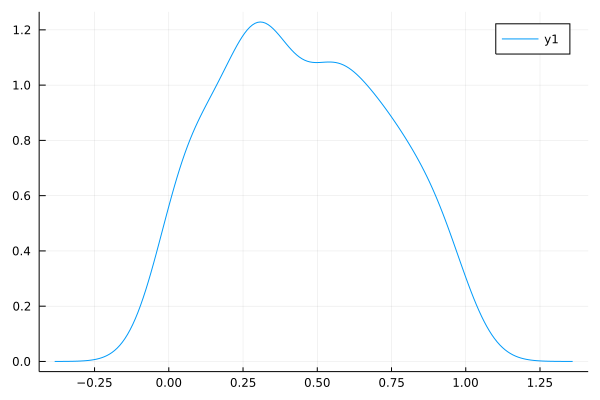

In [217]:
s = rand( filldist(Beta(1,1),100))
density(s)

In [242]:
g = rand(filldist(Truncated(Beta(1,1), 0, 1 .- s)))

LoadError: MethodError: no method matching Truncated(::Beta{Float64}, ::Int64, ::Vector{Float64})
[0mClosest candidates are:
[0m  Truncated(::UnivariateDistribution{S} where S<:ValueSupport, ::Integer, [91m::Integer[39m) at C:\Users\axs162731\.julia\packages\Distributions\cNe2C\src\truncate.jl:70
[0m  Truncated(::UnivariateDistribution{S} where S<:ValueSupport, ::T, [91m::T[39m) where T<:Real at C:\Users\axs162731\.julia\packages\Distributions\cNe2C\src\truncate.jl:61
[0m  Truncated(::UnivariateDistribution{S} where S<:ValueSupport, ::Real, [91m::Real[39m) at deprecated.jl:70
[0m  ...

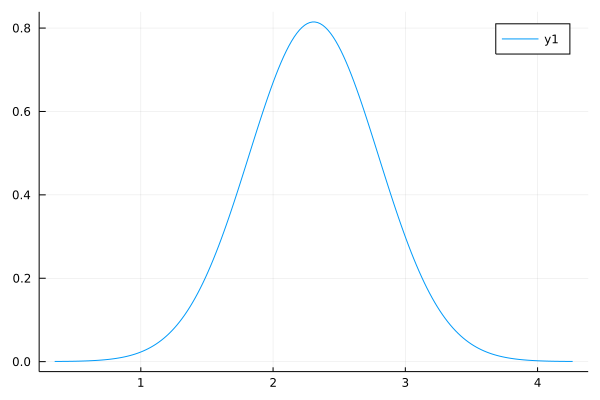

In [251]:
g = rand(Truncated.(Beta(1,1), -2,1.0 .-s))
density(g)